In [51]:
import pandas as pd
import numpy as np
import seaborn as sns

data = pd.read_csv('new_synthetical_dataset.csv')
data.head(5)

Index                                     Address  \
0      1  0x00009277775ac7d0d59eaad8fee3d10ac6c805e8   
1      2  0x0002b44ddb1476db43c868bd494422ee4c136fed   
2      3  0x0002bda54cb772d040f779e88eb453cac0daa244   
3      4  0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e   
4      5  0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89   

   Time Diff between first and last (Mins)  Face Attempts  \
0                                704785.63              1   
1                               1218216.73              1   
2                                516729.30              3   
3                                397555.90              2   
4                                382472.42              1   

   Detected As a Robot At Least Once  Face Match Percentage  \
0                                  0              95.897539   
1                                  0             100.000000   
2                                  0              95.055751   
3                                  0              97.410889   
4                                  0              92.543958   

   Liveness Score of The Face  FLAG  
0                       94.13     0  
1                       93.65     0  
2                       78.86     0  
3                       99.82     0  
4                       92.95     0

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Index                                    9841 non-null   int64  
 1   Address                                  9841 non-null   object 
 2   Time Diff between first and last (Mins)  9841 non-null   float64
 3   Face Attempts                            9841 non-null   int64  
 4   Detected As a Robot At Least Once        9841 non-null   int64  
 5   Face Match Percentage                    9841 non-null   float64
 6   Liveness Score of The Face               9841 non-null   float64
 7   FLAG                                     9841 non-null   int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 615.2+ KB


In [53]:
train_data = data.copy()

In [54]:
from Crypto.Hash import keccak

def hash_address(address):
    keccak_hash = keccak.new(digest_bits=256)
    keccak_hash.update(address.encode())
    decimal_address = int(keccak_hash.hexdigest(), 16)
    return decimal_address

train_data['Address'] = train_data['Address'].apply(hash_address)
train_data['Address']

0       1029047895622181677082469178525025497239514033...
1       4815723412368990051845724797393104504732869074...
2       2267735954664873608345593168102949699911173861...
3       4816189373093903701735752654589308415626257088...
4       1075129388385622703205300713771774172281445551...
                              ...                        
9836    9796640894092615620455712647689124977578652145...
9837    1161781100425295333303255116631183873055342538...
9838    3258899527227816394779062129406231769231685409...
9839    6495764806995869469487631250138285433318644209...
9840    1808180123772589239611473807552879038033015564...
Name: Address, Length: 9841, dtype: object

In [55]:
min(train_data['Address']), max(train_data['Address'])

(6916888273301919839494136598466689873733750117887819555855366265435264500,
 115785804335479085432931386094244858531505116412641089759401603616989508692117)

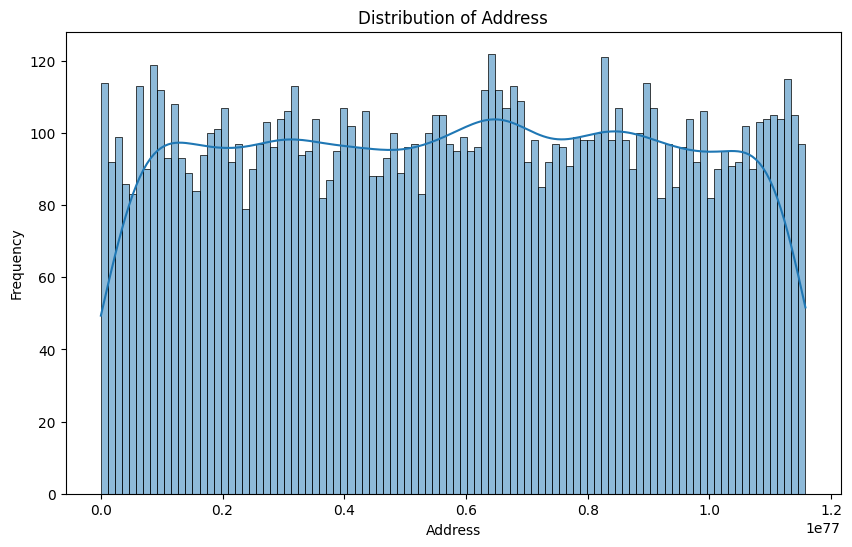

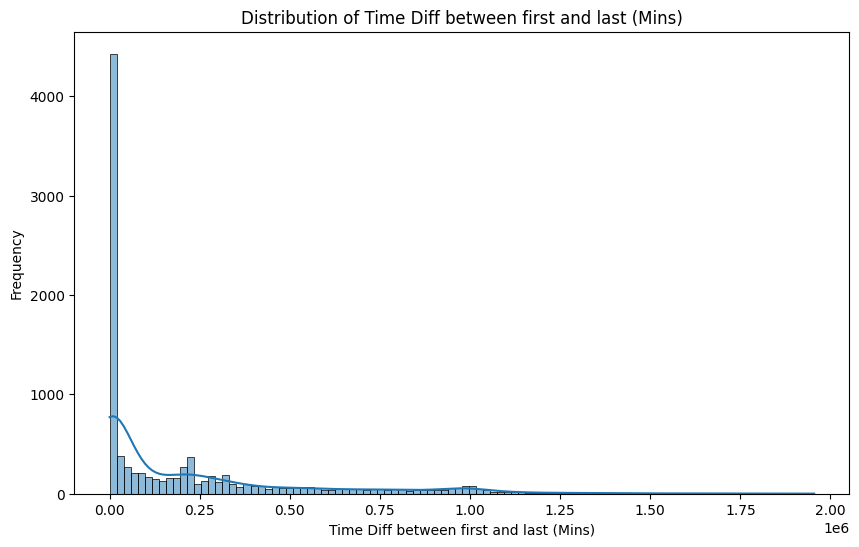

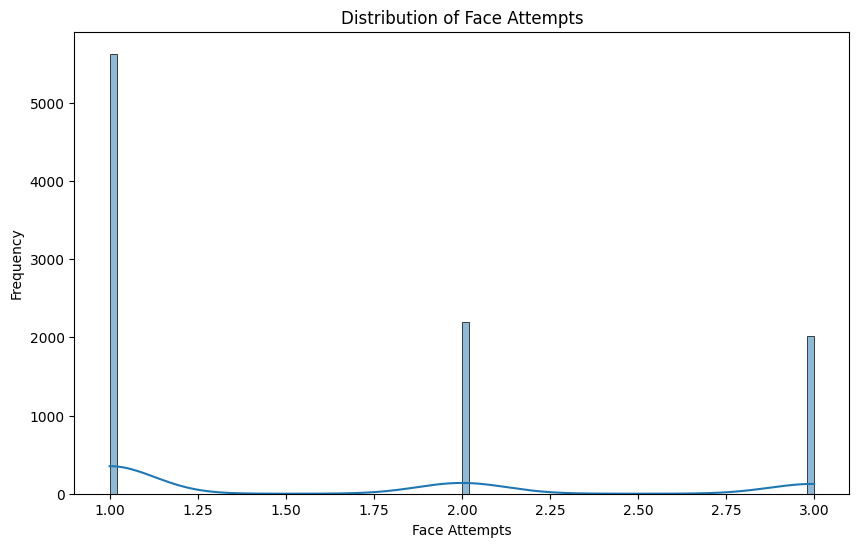

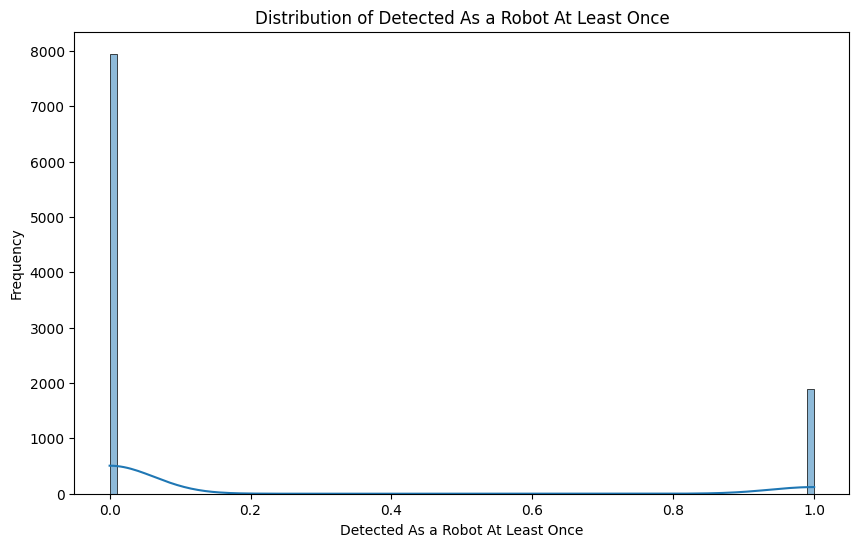

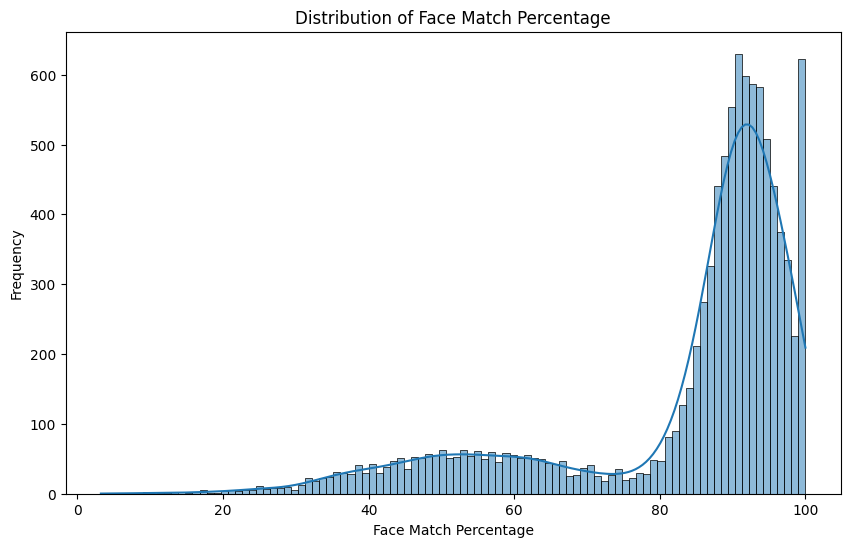

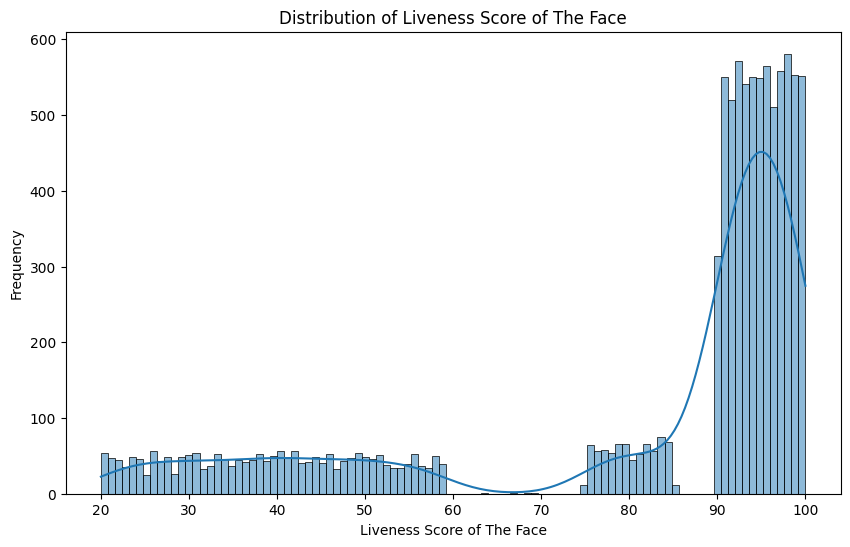

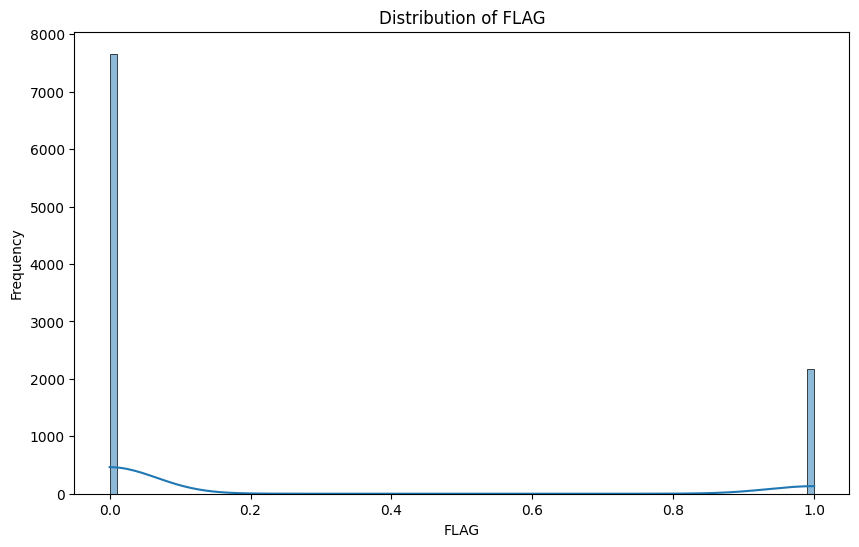

In [56]:
import matplotlib.pyplot as plt

cols = train_data.drop(columns=['Index']).columns
for col in cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(train_data[col], bins=100, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [57]:
train_data.skew().sort_values(ascending=False)

Time Diff between first and last (Mins)    1.809977
Detected As a Robot At Least Once          1.563755
FLAG                                         1.3421
Face Attempts                              0.757758
Index                                       0.57297
Address                                    -0.00933
Liveness Score of The Face                -1.389432
Face Match Percentage                     -1.633101
dtype: object

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for col in train_data.drop(columns=['Index', 'FLAG']):
    train_data[col] = scaler.fit_transform(train_data[col].values.reshape(-1, 1))

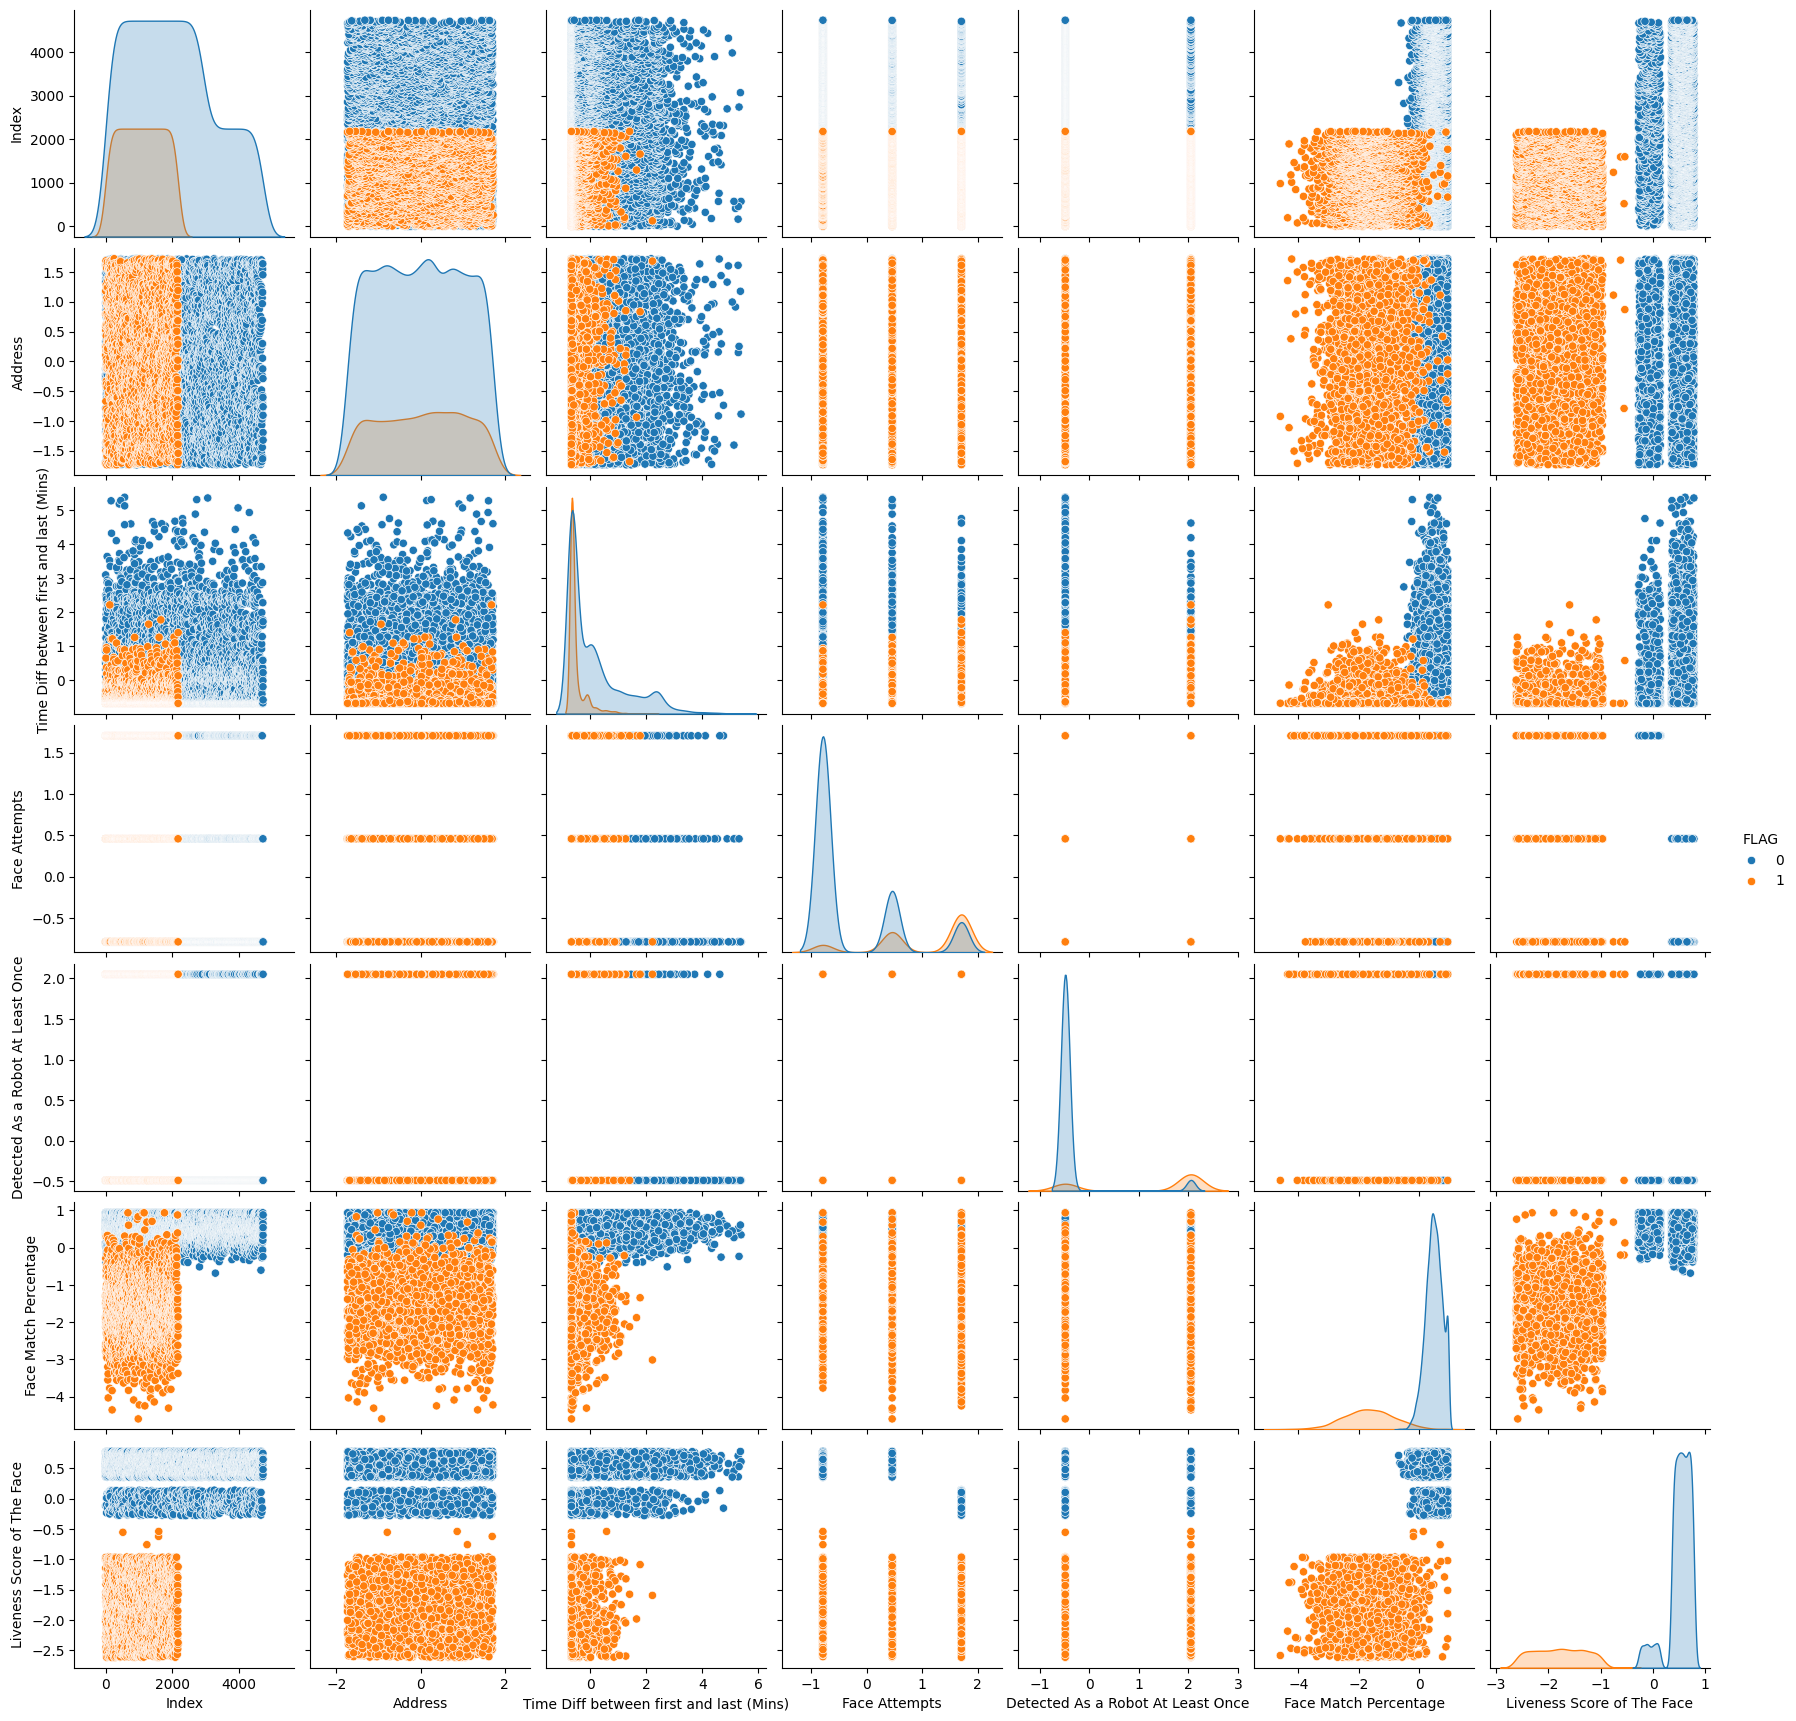

In [59]:
sns.pairplot(data=train_data, diag_kind='kde', hue='FLAG')
plt.show()

In [60]:
from sklearn.ensemble import IsolationForest

iso_forest_model = IsolationForest(contamination=0.1, random_state=42)
iso_forest_model.fit(train_data.drop(columns=['Index', 'FLAG']))

train_data['anomaly'] = iso_forest_model.predict(train_data.drop(columns=['Index', 'FLAG']))
train_data['anommaly'] = train_data['anomaly'].replace({1: 0, -1: 1}, inplace=True)

train_data['anomaly'].value_counts()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8932\940866785.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['anommaly'] = train_data['anomaly'].replace({1: 0, -1: 1}, inplace=True)


anomaly
0    8857
1     984
Name: count, dtype: int64

In [61]:
train_data[['anomaly', 'FLAG']].value_counts()

anomaly  FLAG
0        0       7440
         1       1417
1        1        762
         0        222
Name: count, dtype: int64

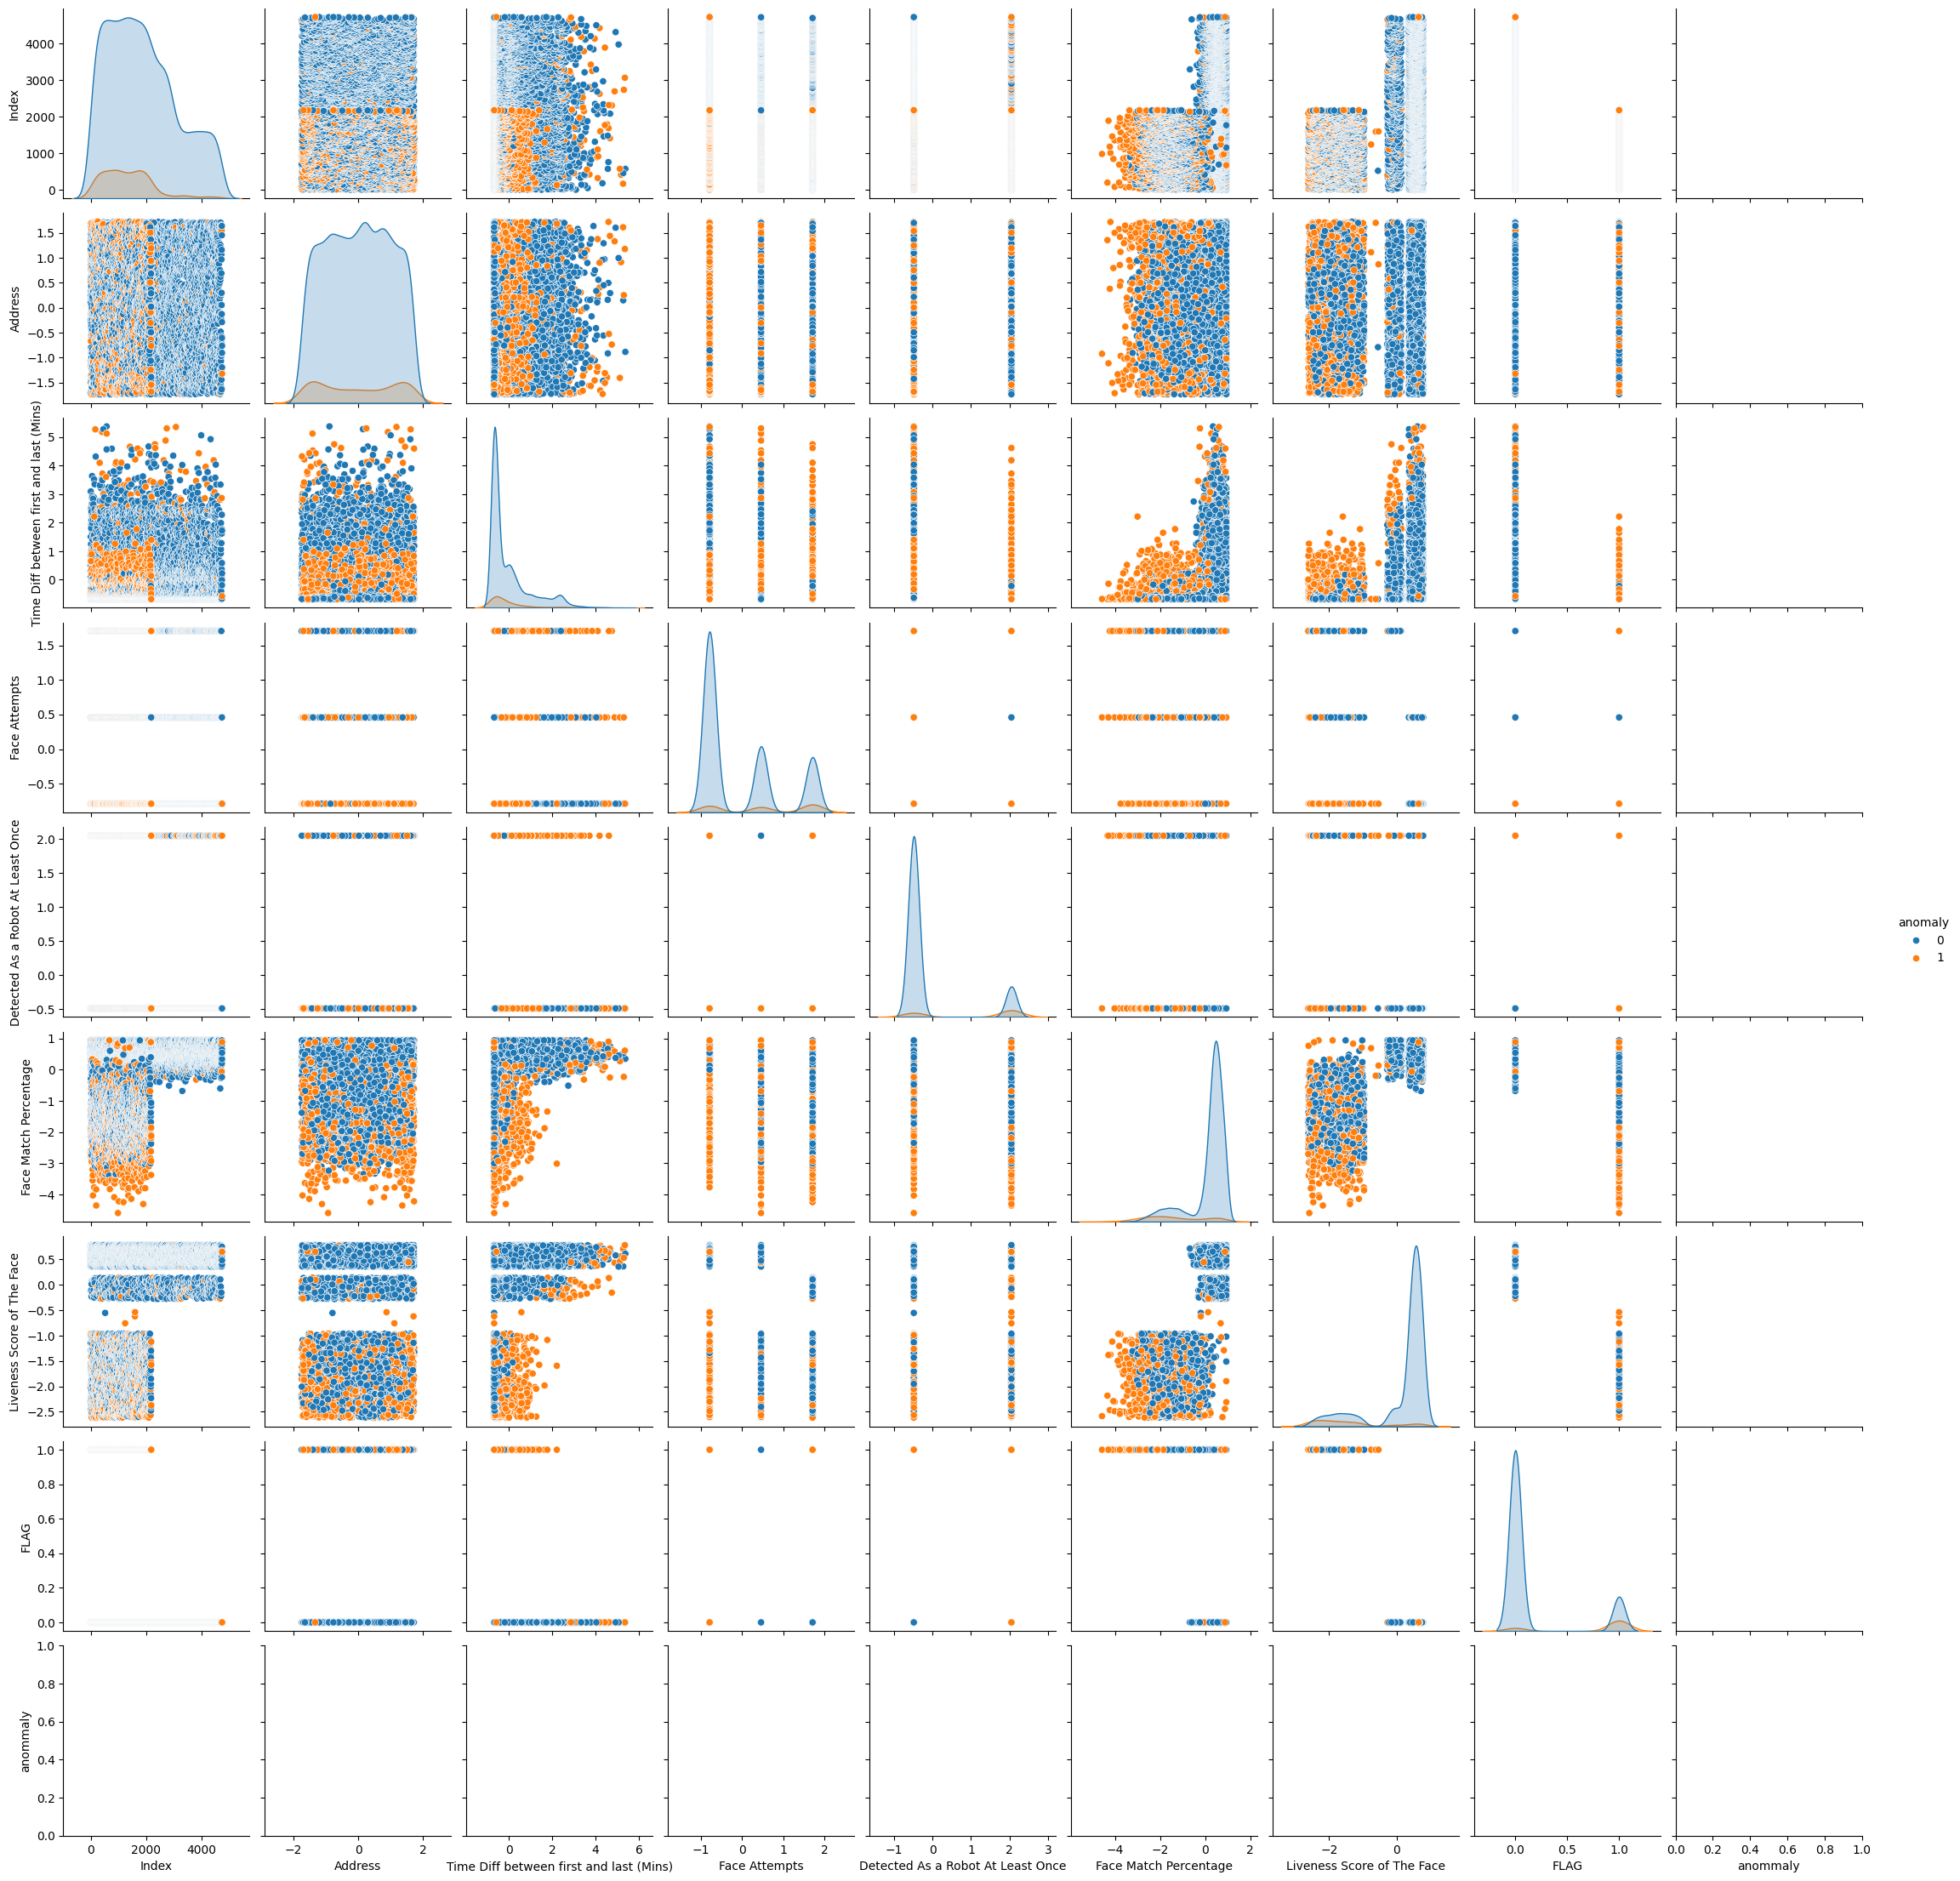

In [62]:
sns.pairplot(data=train_data, diag_kind='kde', hue='anomaly')
plt.show()

In [63]:
import joblib

joblib.dump(iso_forest_model, 'fraud_detection_api/model/isolation_forest_model.pkl')

['fraud_detection_api/model/isolation_forest_model.pkl']

In [64]:
isolation_forest_preds = pd.DataFrame({
    'Address': data['Address'],
    'Anomaly': train_data['anomaly'],
})
isolation_forest_preds.to_csv('isolation_forest_preds.csv', index=False)